In [1]:
import shap
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import lightgbm as lgb

from sklearn.metrics import (
    r2_score, max_error, mean_absolute_error, mean_squared_error,
    mean_absolute_percentage_error, make_scorer
)
from sklearn.model_selection import (
    TimeSeriesSplit, train_test_split, cross_val_score)

from glob import glob
import os
import optuna
import joblib
from tqdm import tqdm, tqdm_notebook
import json

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import plot_init as pu

src_date = "2023-06-17" 


import psutil
    
ram_gb = psutil.virtual_memory().total / 2**30 # total physical memory in bytes
print(f"RAM: {ram_gb:.2f} GB")



/opt/conda/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/opt/conda/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


RAM: 251.54 GB


In [2]:
def get_stderr(arr):
    return np.std(arr, ddof=1) / np.sqrt(np.size(arr))
get_stderr.__name__ = 'stderr'

def rmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

def _change_bf_name(name):
    rename_map = {
        'all': '50-1000',
        '50-50' : '50',
        '100-100': '100',
        '150-150': '150',
        '200-200': '200',
        '250-250': '250',
        '500-500': '500',
        '1000-1000': '1000',
    }
    return rename_map.get(name, name)


## Load results

In [3]:
# SANITY CHECK
from itertools import product

buffer_ablation = [
    'all', # [50, 100, 150, 200, 250, 500],
    [50, 100, 150, 200, 250, 500],
    [50, 100, 150, 200, 250],
    [50, 100, 150, 200],
    [50, 100, 150],
    [50, 100],
    [1000],
    [500],
    [250],
    [200],
    [150],
    [100],
    [50], 
]


etypes = [
    "all_features",
    "landuse_and_time", # queue this with the ablation
    "landuse_only",
]

exp_combis = product(etypes, buffer_ablation)

skip_keys = []

# fold, feature set, buffer range, metric 1 metric 2 metric 3 etc 
tscv_results = []

# feature set, buffer range, metric 1 metric 2 metric 3 etc
test_results = []
for combi in tqdm(exp_combis):
    experiment_type = combi[0]
    buffers = combi[1]
    
    study_name = f'{experiment_type}'
    
    if buffers=='all':
        buffers = buffers
    else:
        buffers = "-".join([str(buffers[0]), str(buffers[-1])])

    optuna_dir = f'../experiments/post-review/{buffers}/{src_date}'

    
    if not os.path.exists(os.path.join(optuna_dir, f"{study_name}.db")):
        print(f"NO OPTUNA STUDY: {buffers}-{experiment_type}")
    
    tscv_results_dir = f"../datasets/results/post-review/tscv/{buffers}/{src_date}"
    fname = f"{experiment_type}.json"
    if not os.path.exists(os.path.join(tscv_results_dir, fname)):
        print(f"NO TSCV: {buffers}-{experiment_type}")
    else:
        res_fp = os.path.join(os.path.join(tscv_results_dir, fname))
        with open(res_fp, 'r') as handle:
            res_data = json.load(handle)
        feature_set = res_fp.split("/")[-1].split(".")[0]
        buffer_range = res_fp.split("/")[-3]
        
        for fold, metrics_dict in res_data.items():
            temp_data = {
                'fold' : fold, 
                'feature_set' : feature_set,
                'buffer_range' :  buffer_range,
            }
            
            for metric, score in metrics_dict.items():
                if metric in skip_keys:
                    continue
                temp_data[metric] = score
            tscv_results.append(temp_data)
            
        
    final_results_dir = f"../datasets/results/post-review/final_results/{buffers}/{src_date}"
    fname = f"{experiment_type}.json"
    if not os.path.exists(os.path.join(final_results_dir, fname)):
        print(f"NO FINAL RESULTS: {buffers}-{experiment_type}")
    else:    
        res_fp = os.path.join(os.path.join(final_results_dir, fname))
        with open(res_fp, 'r') as handle:
            res_data = json.load(handle)
        temp_data = {    
            'feature_set' : res_fp.split("/")[-1].split(".")[0],
            'buffer_range' :  res_fp.split("/")[-3],
        }
        for metric, score in res_data.items():
            if metric in skip_keys:
                continue
            temp_data[metric] = score
        test_results.append(temp_data)


6it [00:28,  4.77s/it]


KeyboardInterrupt: 

### TSCV results to frame

In [4]:
# tscv results to frame
skip_keys = ['y_true', 'y_pred',]
no_yyhat_tscv_res = [
    {k : v for k,v in res.items() if not k in skip_keys} 
    for res in tscv_results
]

# tscv frame
tscv_res_df = pd.DataFrame().from_dict(no_yyhat_tscv_res)
tscv_res_df['buffer_range'] = tscv_res_df['buffer_range'].apply(_change_bf_name)

# add baseline
tscv_bl_path = f"../datasets/results/post-review/tscv/baseline/{src_date}/baseline.json"
with open(tscv_bl_path, 'r') as handle:
    tscv_baseline = json.load(handle)
    
# extract bl results    
tscv_bl_results = []
skip_keys = []
for fold, metrics_dict in tscv_baseline.items():
    temp_data = {
        'fold' : fold, 
        'feature_set' : 'baseline',
        'buffer_range' :  'baseline',
    }
    for metric, score in metrics_dict.items():
        if metric in skip_keys:
            continue
        temp_data[metric] = score
    tscv_bl_results.append(temp_data)
    
# append bl to tscv results data
tscv_results.extend(tscv_bl_results)

# append bl to tscv frame
skip_keys = ['y_true', 'y_pred']
no_yyhat_tscv_bl = [
    {k : v for k,v in res.items() if not k in skip_keys} 
    for res in tscv_bl_results
]
tscv_res_df = tscv_res_df.append(no_yyhat_tscv_bl, ignore_index=True)

In [5]:
tscv_nan_mask = {}

for res in tscv_results:
    if res['feature_set']=='baseline':
        tscv_nan_mask[res['fold']] = np.isnan(np.array(res['y_pred']))

new_tscv_results = []        
for res in tscv_results:
    res['nan_mask'] = tscv_nan_mask[res['fold']]
    new_tscv_results.append(res)
    
tscv_results = new_tscv_results

### Test results to frame

In [6]:
# test results to frame
skip_keys = ['y_true', 'y_pred',]
no_yyhat_test_res = [
    {k : v for k,v in res.items() if not k in skip_keys} 
    for res in test_results
]
test_res_df = pd.DataFrame().from_dict(no_yyhat_test_res)
test_res_df['buffer_range'] = test_res_df['buffer_range'].apply(_change_bf_name)


# add baseline    
test_bl_path = f"../datasets/results/post-review/final_results/baseline/{src_date}/baseline.json"
with open(test_bl_path, 'r') as handle:
    test_baseline = json.load(handle)

# extract bl results    
test_bl_results = []
temp_data = {
    'feature_set' : 'baseline',
    'buffer_range' :  'baseline',
}
skip_keys = []
for metric, score in test_baseline.items():
    if metric in skip_keys:
        continue
    temp_data[metric] = score
test_bl_results = [temp_data]

# append bl to test results data
test_results.extend(test_bl_results)


# append bl to test frame
skip_keys = ['y_true', 'y_pred']
no_yyhat_test_bl = [
    {k : v for k,v in res.items() if not k in skip_keys} 
    for res in test_bl_results
]
test_res_df = test_res_df.append(no_yyhat_test_bl, ignore_index=True)

In [7]:
for res in test_results:
    if res['feature_set'] == 'baseline':
        test_nan_mask = np.isnan(np.array(res['y_pred']))

new_test_results = []
for res in test_results:
    res['nan_mask'] = test_nan_mask
    new_test_results.append(res)

## Plotting results

### TSCV: Std Err

In [8]:
non_metric_cols = ['fold', 'feature_set', 'buffer_range',]
metric_cols = [
    col for col in tscv_res_df.columns if not col in non_metric_cols
]

tscv_res_df['feature_set'].unique()

array(['all_features', 'landuse_and_time', 'landuse_only', 'baseline'],
      dtype=object)

In [9]:
data = tscv_res_df

In [10]:
# agg by fold
agg_res = tscv_res_df.groupby(['feature_set', 'buffer_range']).agg({
    metric : ['mean', get_stderr] for metric in metric_cols
})

# sort by metric
metric = 'rmse'

ascending = [False, True]
if metric != 'r2':
    ascending = [True, True]

agg_res.sort_values(by=[(metric, 'mean'), (metric, 'stderr')], ascending=ascending)


# group by feature set
x = 'buffer_range'
hue = 'feature_set'
labelpad = 10
label_size = pu.large * 1.2
tick_label_size = pu.large

figsize = (
    pu.figsizes['double'][0] * 1.5,
    pu.figsizes['double'][1] * 0.8 * 2,
  )

fig, ax = plt.subplots(2, 1, figsize=figsize)

metric = 'r2'
sns.pointplot(x=x, y=metric, hue=hue, data=data, errorbar='se',
    ax=ax[0],
)
ax[0].set_ylim(0.2, 0.75)
ax[0].get_legend().remove()
ax[0].set_xlabel('')
ax[0].set_ylabel(
    ax[0].get_ylabel(), fontsize=label_size, labelpad=labelpad)


metric = 'rmse'
sns.pointplot(x=x, y=metric, hue=hue, data=data, errorbar='se',
    ax=ax[1],
)


# get legend for figure level legend
handles, labels = ax[1].get_legend_handles_labels()
ax[1].get_legend().remove()
ax[1].set_ylim(6, 9.5)
ax[1].set_ylabel(
    ax[1].get_ylabel(), fontsize=label_size, labelpad=labelpad)
ax[1].set_xlabel(
    ax[1].get_xlabel(), fontsize=label_size, labelpad=labelpad)

fig.legend(
    handles, labels, 
    loc='upper center', 
    ncol=4, 
    labelspacing=0,
    fontsize='medium', # xx-small, 'x-xmall', 'small', 'x-large' etc,
    reverse=True,
)

for axes in ax:
    axes.tick_params(
        axis='both', which='major', labelsize=tick_label_size,
    )

sns.despine(offset=5, trim=True)
plt.tight_layout()
plt.show()


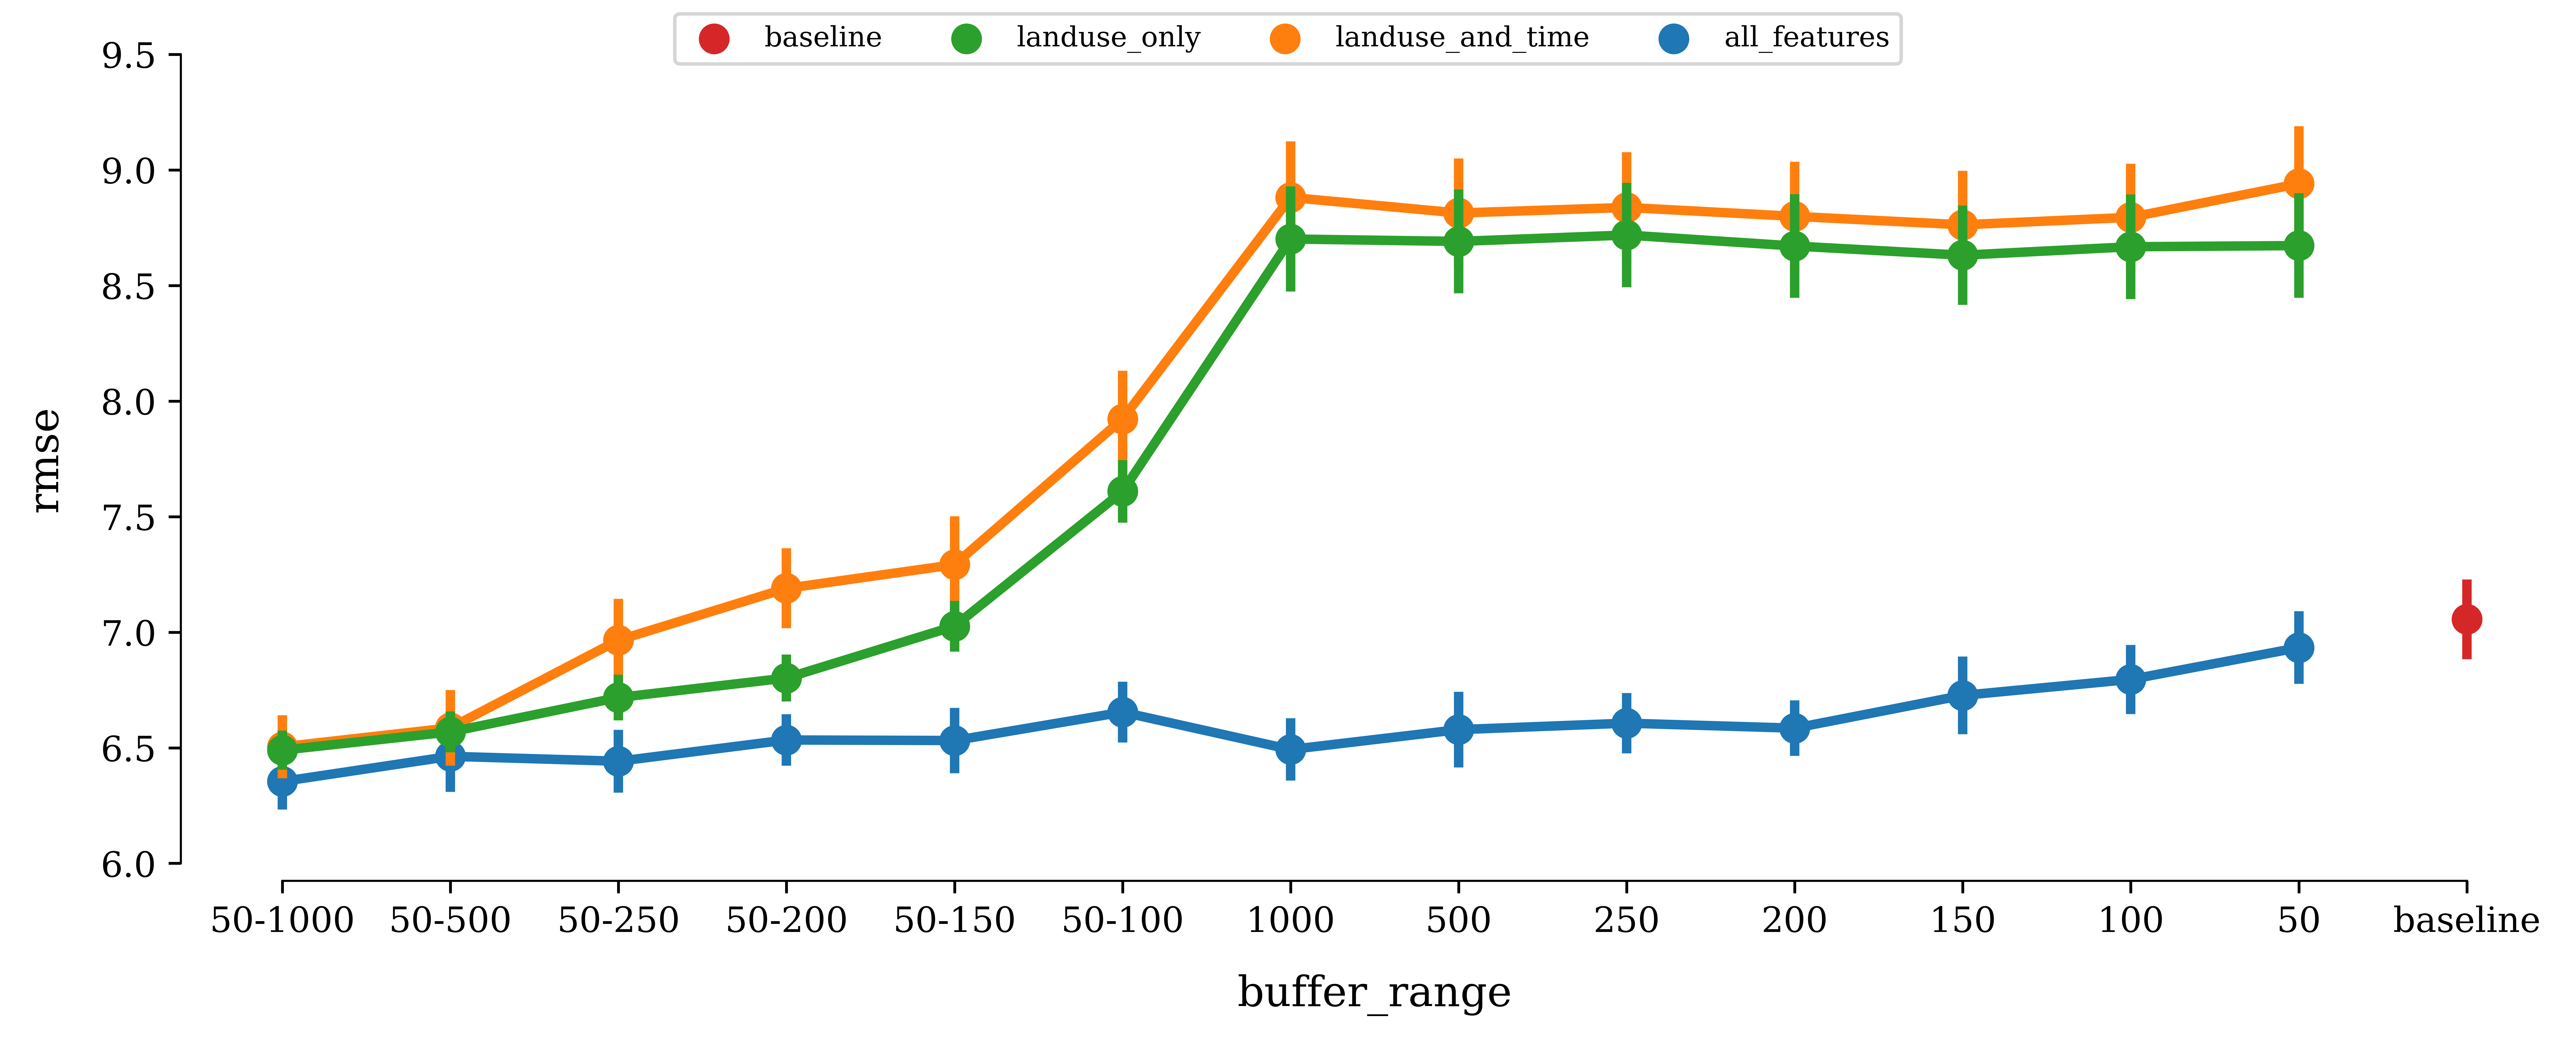

In [11]:

# group by feature set
figsize = (
    pu.figsizes['double'][0] * 1.5,
    pu.figsizes['double'][1] * 0.8,
  )

fig, ax = plt.subplots(figsize=figsize)

metric = 'rmse'
sns.pointplot(
    x=x, y=metric, hue=hue, data=data, errorbar='se',
    ax=ax, 
#     errwidth=2, capsize=2, linestyles='--',  
)
# get legend for figure level legend
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()

fig.legend(
    handles, labels, 
    loc='upper center', 
    ncol=4, 
    labelspacing=0,
    fontsize='medium', # xx-small, 'x-xmall', 'small', 'x-large' etc,
    reverse=True,
)

ax.set_xlabel(
    ax.get_xlabel(), fontsize=label_size, labelpad=labelpad)

ax.set_ylabel(
    ax.get_ylabel(), fontsize=label_size, labelpad=labelpad)

ax.tick_params(axis='both', which='major', labelsize=tick_label_size,
)
plt.ylim(6, 9.5)
sns.despine(offset=5, trim=True)
plt.tight_layout()
plt.show()


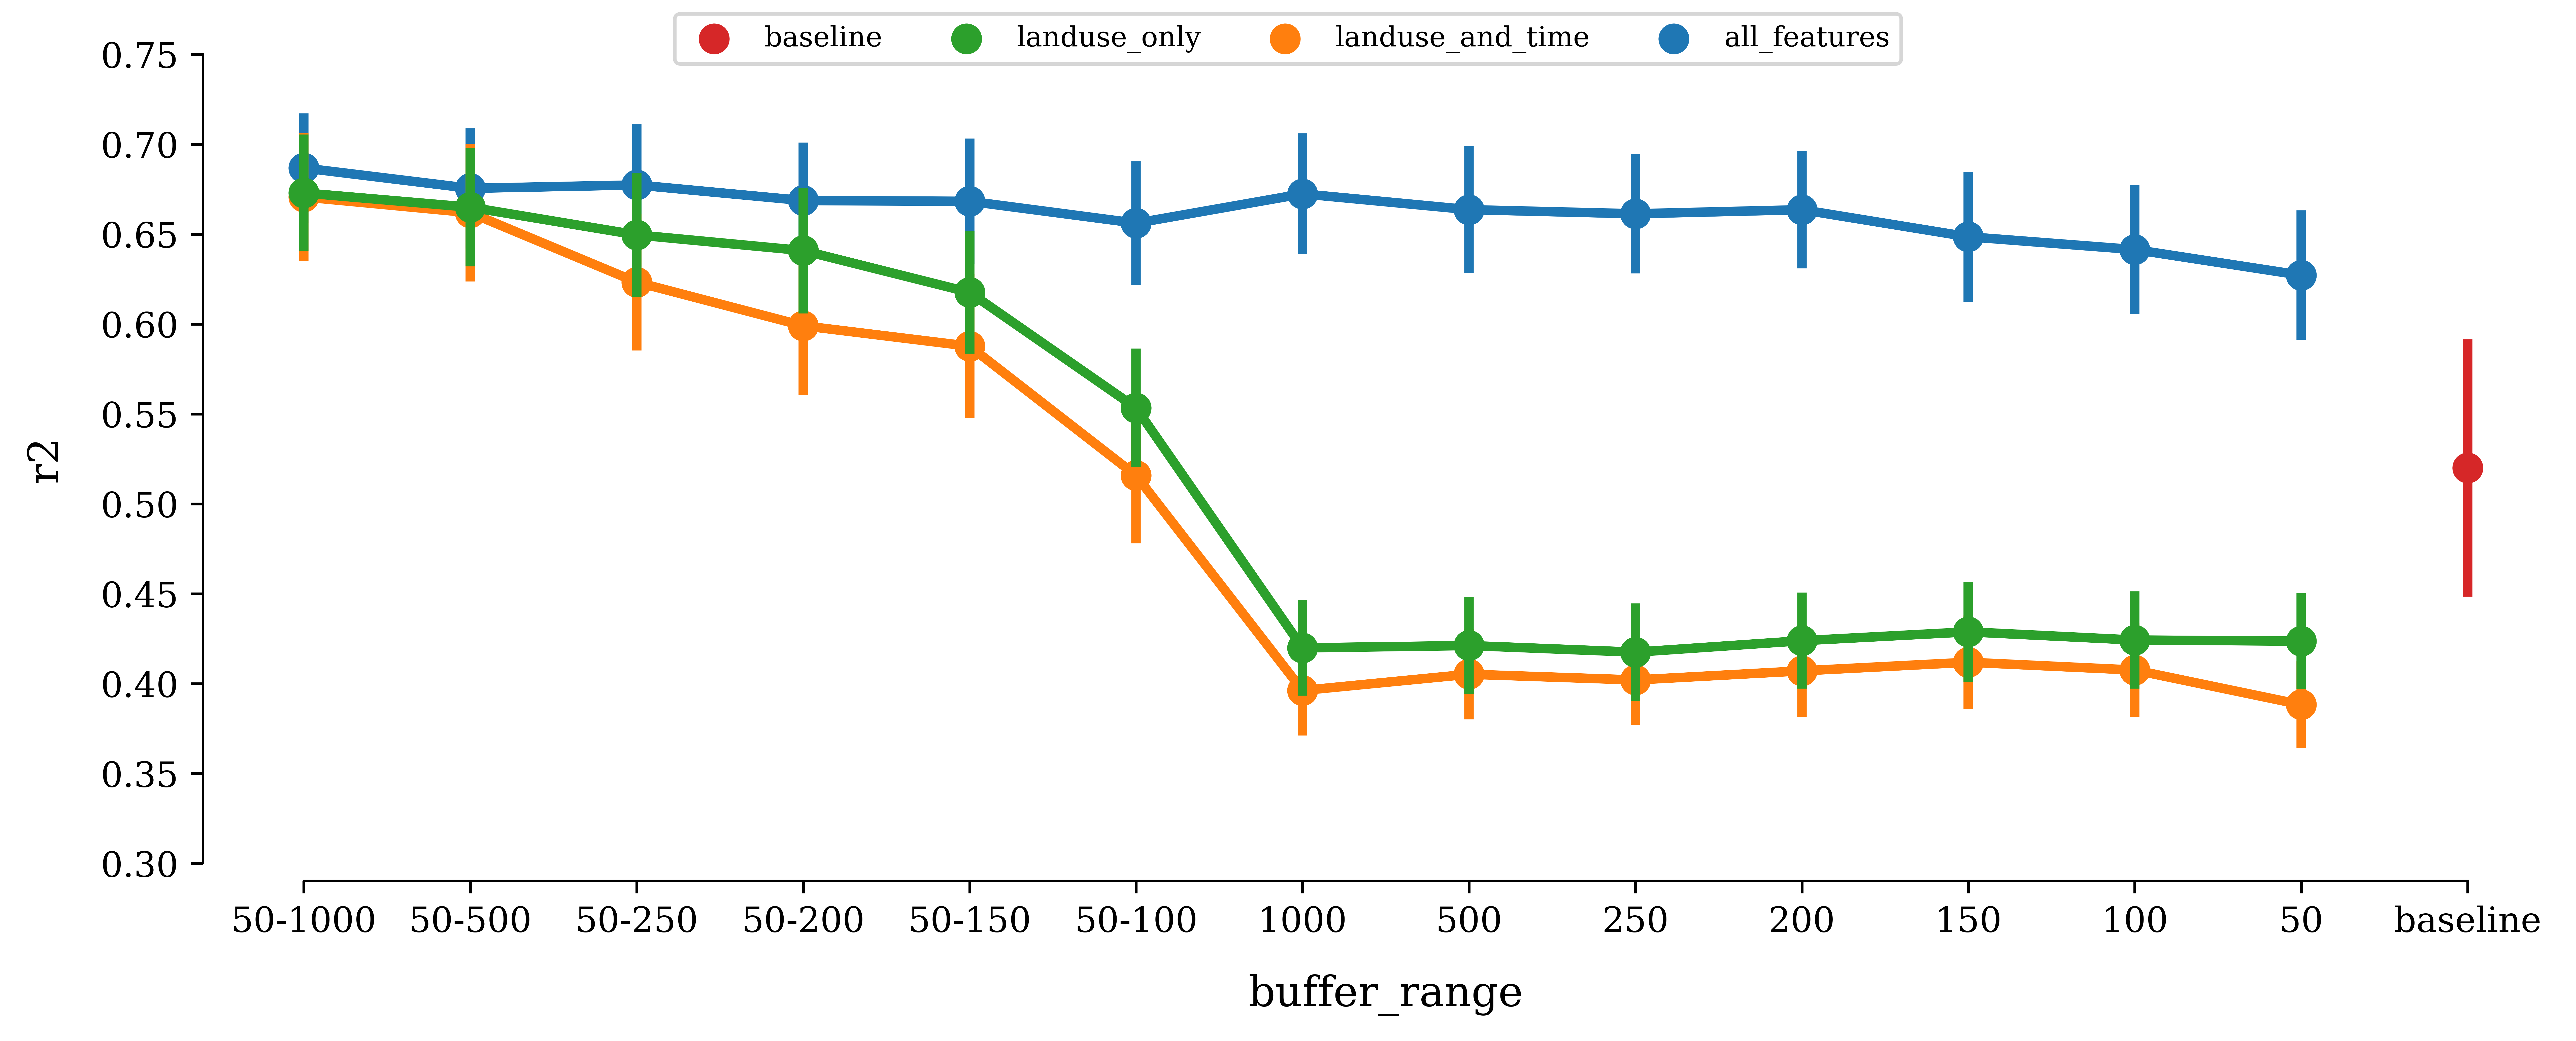

In [12]:
# group by feature set
fig, ax = plt.subplots(figsize=figsize)
x = 'buffer_range'
hue = 'feature_set'
labelpad = 10
label_size = pu.large * 1.2
tick_label_size = pu.large

metric = 'r2'
sns.pointplot(x=x, y=metric, hue=hue, data=data, errorbar='se',
    ax=ax,
)
# get legend for figure level legend
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()

fig.legend(
    handles, labels, 
    loc='upper center', 
    ncol=4, 
    labelspacing=0,
    fontsize='medium', # xx-small, 'x-xmall', 'small', 'x-large' etc,
    reverse=True,
)

ax.set_xlabel(
    ax.get_xlabel(), fontsize=label_size, labelpad=labelpad)

ax.set_ylabel(
    ax.get_ylabel(), fontsize=label_size, labelpad=labelpad)

ax.tick_params(axis='both', which='major', labelsize=tick_label_size,
)
plt.ylim(0.3, 0.75)
sns.despine(offset=5, trim=True)
plt.tight_layout()
plt.show()


## Bootstrapped results

In [13]:
# utils
import numpy as np
import scipy.stats

# parallelize bootstraps
import multiprocessing as mp

def _get_sample_score(bs_true, bs_pred, scorer):
    # GET NON-NAN MASK
    non_nan_mask = ~np.isnan(bs_pred)
    
    # DROP NANS
    bs_pred = bs_pred[non_nan_mask]
    bs_true = bs_true[non_nan_mask]
    
    return scorer(bs_true, bs_pred)

def _get_nan_mask_score(bs_true, bs_pred, scorer, nan_mask, non_nan=False):
    if non_nan:
        # DROP NANS
        bs_pred = bs_pred[~nan_mask]
        bs_true = bs_true[~nan_mask]
        
        return scorer(bs_true, bs_pred)
    else:
        # SCORE BASELINE NANS
        bs_pred = bs_pred[nan_mask]
        bs_true = bs_true[nan_mask]
        
        return scorer(bs_true, bs_pred)


def get_mean_ci(y_true, y_pred, scorers, nan_mask, conf=0.95, num_bs=10_000):
    """scorers is a dict with metric name as key and scorer as value"""
    bs_scores = []
    for i in range(num_bs):
        rng = np.random.default_rng()
        n = len(y_true)
        bs_index = rng.integers(n, size=n)

        bs_true = np.array(y_true)[bs_index]
        bs_pred = np.array(y_pred)[bs_index]
        
        scores = []
        for metric, scorer in scorers.items():
            # FULL TEST SCORE
            scores.append(
                _get_sample_score(bs_true, bs_pred, scorer)
            )
            # BASELINE NOT NANS
            scores.append(
                _get_nan_mask_score(
                    bs_true, bs_pred, scorer, nan_mask, non_nan=True)
            )
            # BASELINE NANS
            scores.append(
                _get_nan_mask_score(
                    bs_true, bs_pred, scorer, nan_mask, non_nan=False)
            )
            
        bs_scores.append(scores)
    
    # CHANGE scipy.stats.sem to treatment as population
#     m_s, se_s = np.mean(bs_scores, axis=0), scipy.stats.sem(bs_scores, axis=0)
    m_s, std_s = np.mean(bs_scores, axis=0), np.std(bs_scores, ddof=1, axis=0)
    
    # get ci at conf value : note num_bs is the size of bs_scores (rows)
#     h_s = se_s * scipy.stats.t.ppf((1 + conf) / 2., num_bs - 1)
    h_s = std_s * scipy.stats.t.ppf((1 + conf) / 2., num_bs - 1)    
    return m_s, h_s # tup of numpy arrays each with dim = num of scorers used


In [14]:
scipy.stats.t.ppf((1 + 0.95) / 2, 10_000 - 1)

1.9602012636213575

In [17]:
def mp_bootstrap(id_, chunk, num_bs, scorers, focus_list=[]):

    print(' ', end='', flush=True)
    tqdm_text = "#" + "{}".format(id_).zfill(3)
    
    bs_results = [] # list of dictionaries
    for res in tqdm_notebook(chunk, desc=tqdm_text, position=id_):
        if len(focus_list) > 0:
            if not res['feature_set'] in focus_list:
                continue
        else:
            pass

        bf_range = _change_bf_name(res['buffer_range'])
        nan_mask = res['nan_mask']
        
        # RUN BS
        m_s, h_s = get_mean_ci(
            res['y_true'], res['y_pred'], scorers, nan_mask, num_bs=num_bs,
        )
        if 'fold' in res.keys():
            # dictionary of result
            temp_bs_res = {
                'fold': res['fold'],
                'feature_set': res['feature_set'],
                'buffer_range': bf_range,
                'nan_mask': nan_mask,
            }
        else:
            temp_bs_res = {
                'feature_set': res['feature_set'],
                'buffer_range': bf_range,
                'nan_mask': nan_mask,
            }
            
        inc = m_s.size / len(scorers.keys()) # 3
        
        # means and cis
        for index, (metric, scorer) in enumerate(scorers.items()):
            
            start_index = index * inc # 0 * 3, 1 * 3 as start
            
            temp_bs_res[f"{metric}_mean"] = m_s[start_index]
            temp_bs_res[f"{metric}_ci"] = h_s[start_index] 
            
            temp_bs_res[f"{metric}_notnan_mean"] = m_s[start_index + 1]
            temp_bs_res[f"{metric}_notnan_ci"] = h_s[start_index + 1]
            
            temp_bs_res[f"{metric}_nan_mean"] = m_s[start_index + 2]
            temp_bs_res[f"{metric}_nan_ci"] = h_s[start_index + 2]

        bs_results.append(temp_bs_res)

    return bs_results # return list of dictionaries

def parallelize_bs(res_list, func, *args):
    mp.freeze_support()
    cpus = mp.cpu_count()
    chunks = np.array_split(res_list, cpus)
    
        
    pool = mp.Pool(
        processes=cpus,
        initargs=(mp.RLock(),),
        initializer=tqdm.set_lock
    )
    
    chunk_processes = [
        pool.apply_async(
            func, args=(id_, chunk, *args),
        ) for id_, chunk in enumerate(chunks)
    ]
    pool.close()
    results = []
    for chunk in chunk_processes:
        # each chunk returns a list of results
        res = chunk.get()
        
        # add list of dictionary results to results
        results.extend(res)

    return results

### Test set: Bootstrapped CIs

In [ ]:
# focus_list = ['baseline']
focus_list = []
scorers = {'rmse': rmse, 'r2': r2_score}
num_bs = 10_000

bs_test_results = parallelize_bs(test_results, mp_bootstrap, num_bs, scorers, focus_list)

#000:   0%|          | 0/2 [00:00<?, ?it/s]

#001:   0%|          | 0/2 [00:00<?, ?it/s]

#002:   0%|          | 0/2 [00:00<?, ?it/s]

#003:   0%|          | 0/2 [00:00<?, ?it/s]

#004:   0%|          | 0/2 [00:00<?, ?it/s]

#005:   0%|          | 0/2 [00:00<?, ?it/s]

#006:   0%|          | 0/2 [00:00<?, ?it/s]

#007:   0%|          | 0/2 [00:00<?, ?it/s]

#008:   0%|          | 0/1 [00:00<?, ?it/s]

#009:   0%|          | 0/1 [00:00<?, ?it/s]

#010:   0%|          | 0/1 [00:00<?, ?it/s]

#011:   0%|          | 0/1 [00:00<?, ?it/s]

#012:   0%|          | 0/1 [00:00<?, ?it/s]

#013:   0%|          | 0/1 [00:00<?, ?it/s]

#014:   0%|          | 0/1 [00:00<?, ?it/s]

#015:   0%|          | 0/1 [00:00<?, ?it/s]

#016:   0%|          | 0/1 [00:00<?, ?it/s]

#017:   0%|          | 0/1 [00:00<?, ?it/s]

#018:   0%|          | 0/1 [00:00<?, ?it/s]

#019:   0%|          | 0/1 [00:00<?, ?it/s]

#020:   0%|          | 0/1 [00:00<?, ?it/s]

#021:   0%|          | 0/1 [00:00<?, ?it/s]

#022:   0%|          | 0/1 [00:00<?, ?it/s]

#023:   0%|          | 0/1 [00:00<?, ?it/s]

#024:   0%|          | 0/1 [00:00<?, ?it/s]

#025:   0%|          | 0/1 [00:00<?, ?it/s]

#026:   0%|          | 0/1 [00:00<?, ?it/s]

#027:   0%|          | 0/1 [00:00<?, ?it/s]

#028:   0%|          | 0/1 [00:00<?, ?it/s]

#029:   0%|          | 0/1 [00:00<?, ?it/s]

#030:   0%|          | 0/1 [00:00<?, ?it/s]

#031:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
bs_test_df = pd.DataFrame.from_dict(bs_test_results)
display(bs_test_df.head())
bs_test_df.to_csv("bs-test-results-new.csv", index=False)

In [4]:
bs_test_df = pd.read_csv("bs-test-results.csv")

In [ ]:
metric = 'r2'
ascending=True
if metric=='r2':
    ascending=False
bs_test_df.sort_values(by=f'{metric}_mean', ascending=ascending)[:20].reset_index().drop(columns='index')

In [ ]:
bs_test_df.info()

### TSCV: Bootstrapped CIs

In [ ]:
# focus_list = ['baseline']
focus_list = []
scorers = {'rmse': rmse, 'r2': r2_score}
num_bs = 10_000

bs_tscv_results = parallelize_bs(tscv_results, mp_bootstrap, num_bs, scorers, focus_list)

In [ ]:
bs_tscv_df = pd.DataFrame.from_dict(bs_tscv_results)
display(bs_tscv_df.head())
bs_tscv_df.to_csv("bs-tscv-results-new.csv", index=False)

In [ ]:
# bs_tscv_df.info()

In [ ]:
# bs_tscv_df.loc[bs_tscv_df.feature_set=='baseline']

In [5]:
bs_tscv_df = pd.read_csv("bs-tscv-results.csv")

## Plotting bootstrap results

### Test results

In [6]:
data = bs_test_df
group_key = 'feature_set'
# group by feature set
fig, ax = plt.subplots(figsize=figsize)

metric = 'r2'
labelpad = 10
label_size = pu.large * 1.2
tick_label_size = pu.large
cmap = {
    'all_features': 'tab:blue',
    'landuse_only': 'tab:green',
    'baseline': 'tab:red',
    'landuse_and_time': 'tab:orange',
}

for name, group in data.groupby(group_key):
    x = group['buffer_range']
    y = group[f'{metric}_mean']
    yerr = group[f'{metric}_ci']

    # get legend for figure level legend
    ax.errorbar(
        x, y, yerr=yerr,
        marker='o', ms=8,
        ls='--', elinewidth=2, lw=0.5, label=name, c=cmap[name],
        capsize=10,
    )
    ax.legend()
handles, labels = ax.get_legend_handles_labels()

# sort step
hl_dict = dict(zip(labels, handles))
labels = ['baseline', 'landuse_only', 'landuse_and_time', 'all_features']
handles = [hl_dict[i] for i in labels]

ax.get_legend().remove()

fig.legend(
    handles, labels, 
    loc='upper center', 
    ncol=4, 
    labelspacing=0,
    fontsize='medium', # xx-small, 'x-xmall', 'small', 'x-large' etc,
    reverse=False,
)

ax.set_xlabel(
    'buffer_range', fontsize=label_size, labelpad=labelpad)

ax.set_ylabel(
    metric, fontsize=label_size, labelpad=labelpad)

ax.tick_params(axis='both', which='major', labelsize=tick_label_size,
)
ax.set_ylim(0.2, 0.75)
sns.despine(offset=5, trim=True)
plt.tight_layout()
plt.show()


type: name 'figsize' is not defined

### TSCV results

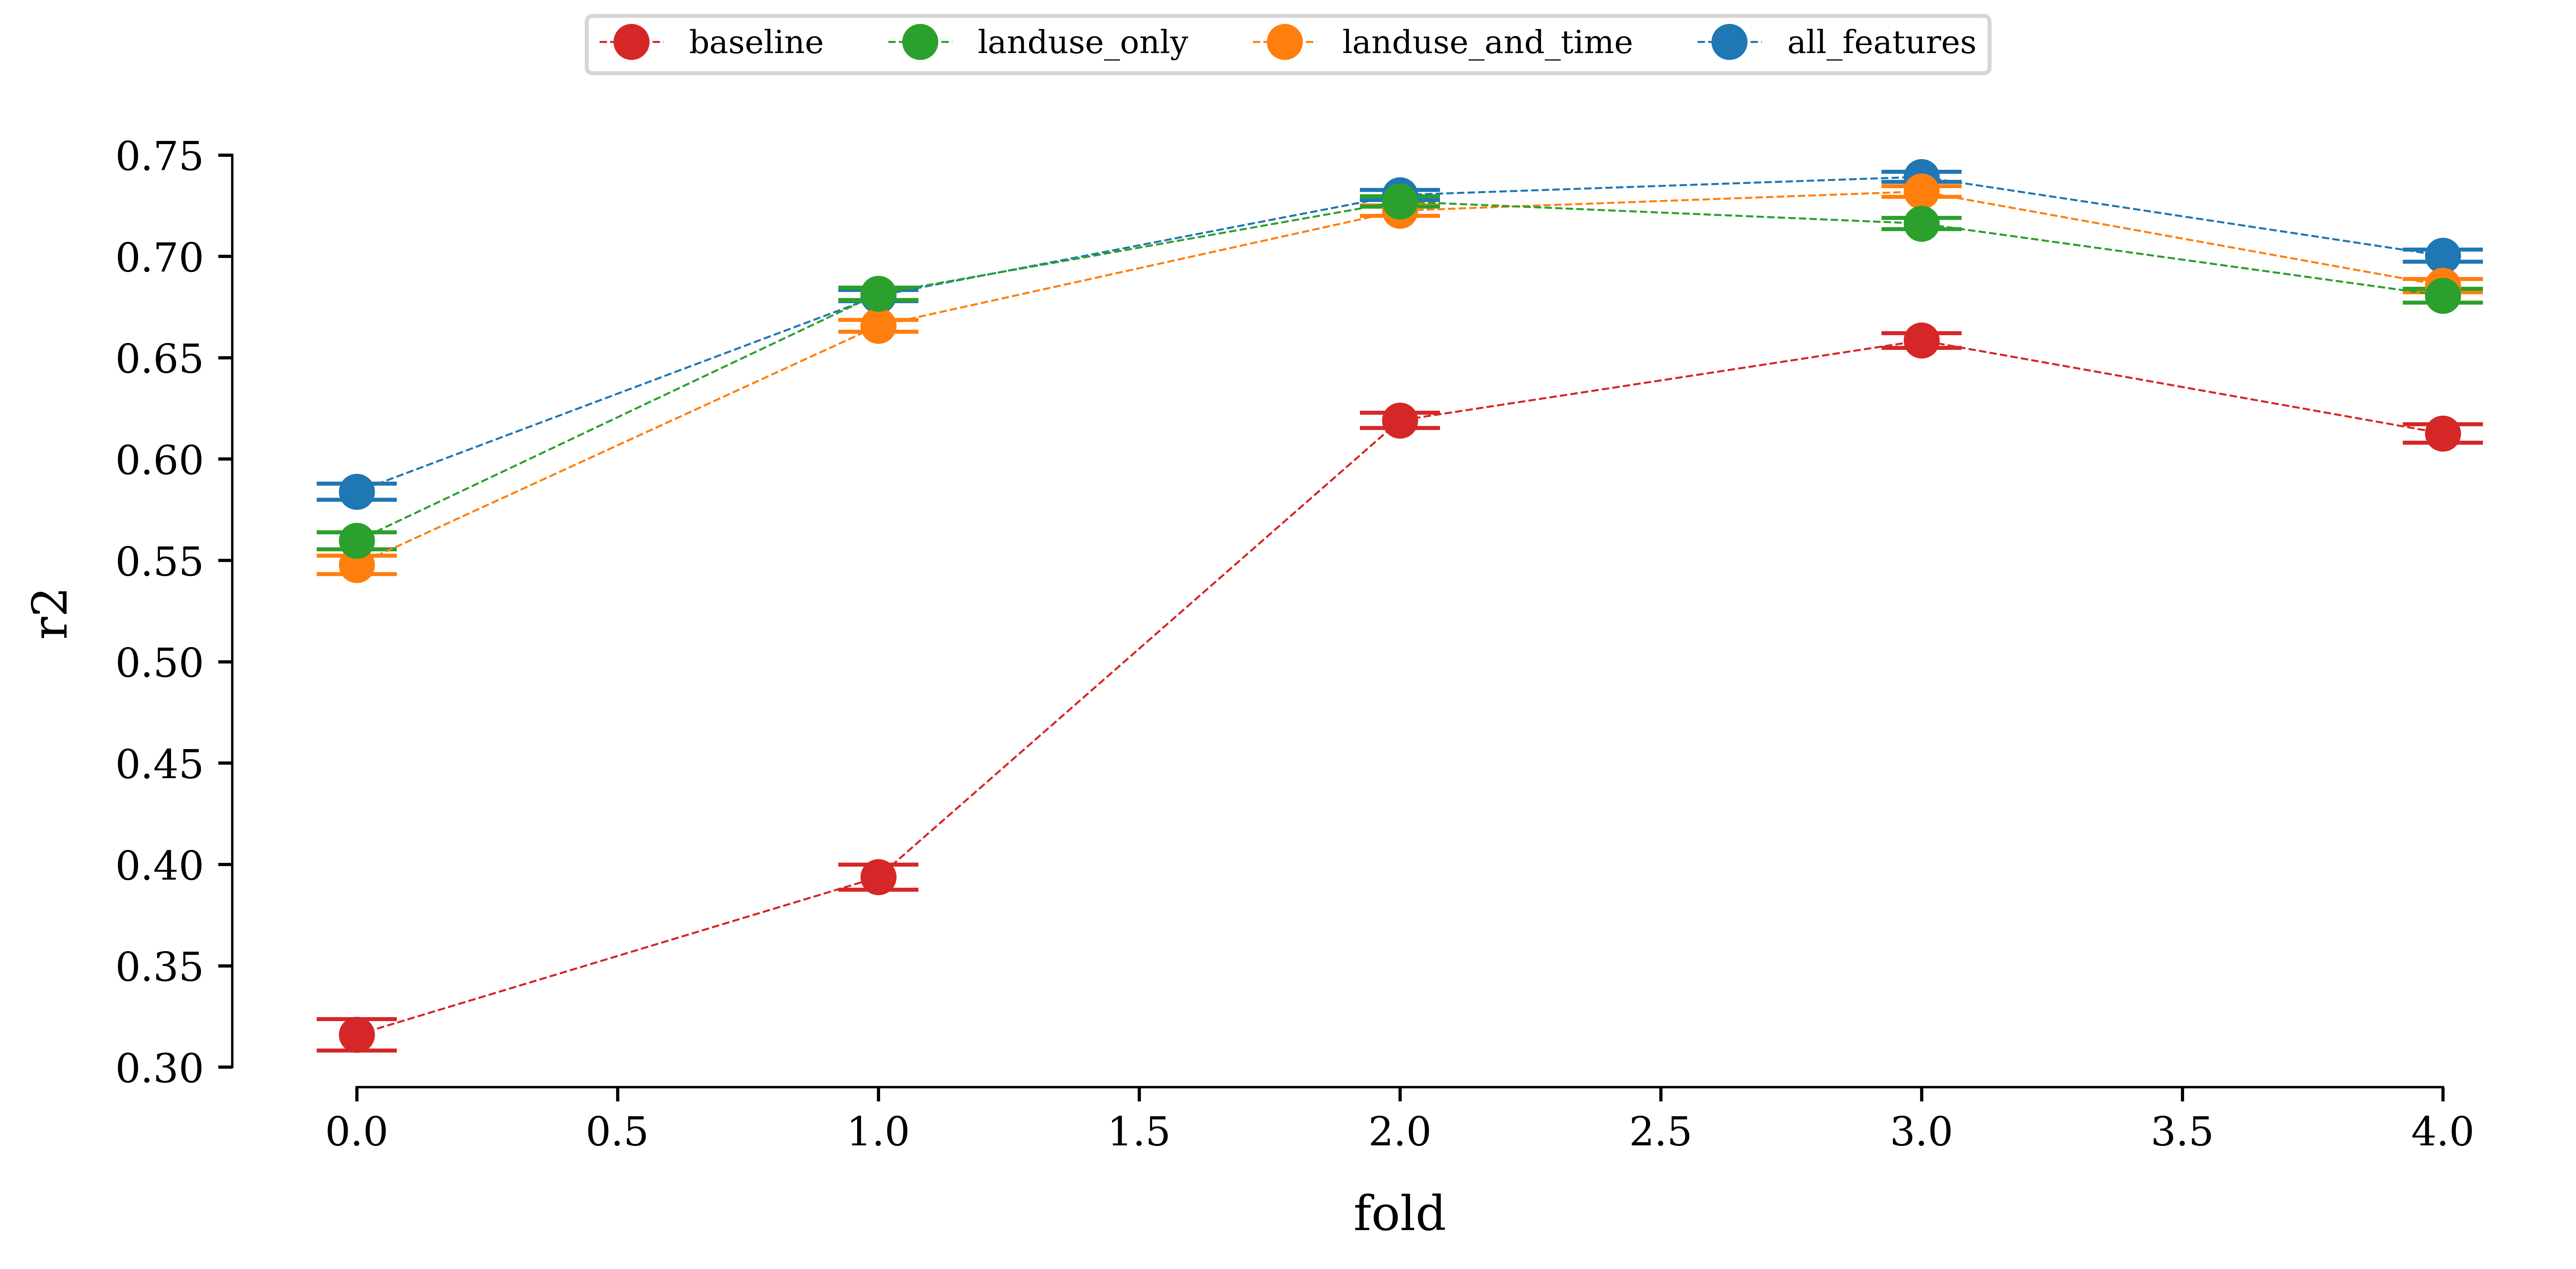

In [7]:
data = bs_tscv_df.loc[
    (bs_tscv_df.buffer_range=='50-1000') |
    (bs_tscv_df.buffer_range=='baseline')
]

group_key = 'feature_set'

# group by feature set
figsize = (
    pu.figsizes['double'][0] * 1.5,
    pu.figsizes['double'][1] * 0.8,
  )
fig, ax = plt.subplots(figsize=figsize)

metric = 'r2'
labelpad = 10
label_size = pu.large * 1.2
tick_label_size = pu.large
cmap = {
    'all_features': 'tab:blue',
    'landuse_only': 'tab:green',
    'baseline': 'tab:red',
    'landuse_and_time': 'tab:orange',
}

for name, group in data.groupby(group_key):
    x = group['fold']
    y = group[f'{metric}_mean']
    yerr = group[f'{metric}_ci']

    # get legend for figure level legend
    ax.errorbar(
        x, y, yerr=yerr,
        marker='o', ms=8, capsize=10, lw=0.5,
        ls='--', elinewidth=2, label=name, c=cmap[name],
    )
    ax.legend()
handles, labels = ax.get_legend_handles_labels()

# sort step
hl_dict = dict(zip(labels, handles))
labels = ['baseline', 'landuse_only', 'landuse_and_time', 'all_features']
handles = [hl_dict[i][0] for i in labels]

ax.get_legend().remove()

fig.legend(
    handles, labels, 
    loc='upper center', 
    ncol=4, 
    labelspacing=0,
    fontsize='medium', # xx-small, 'x-xmall', 'small', 'x-large' etc,
    reverse=False,
)

ax.set_xlabel(
    'fold', fontsize=label_size, labelpad=labelpad)

ax.set_ylabel(
    metric, fontsize=label_size, labelpad=labelpad)

ax.tick_params(axis='both', which='major', labelsize=tick_label_size,
)
ax.set_ylim(0.3, 0.75)
sns.despine(offset=5, trim=True)

# plt.tight_layout()
plt.show()


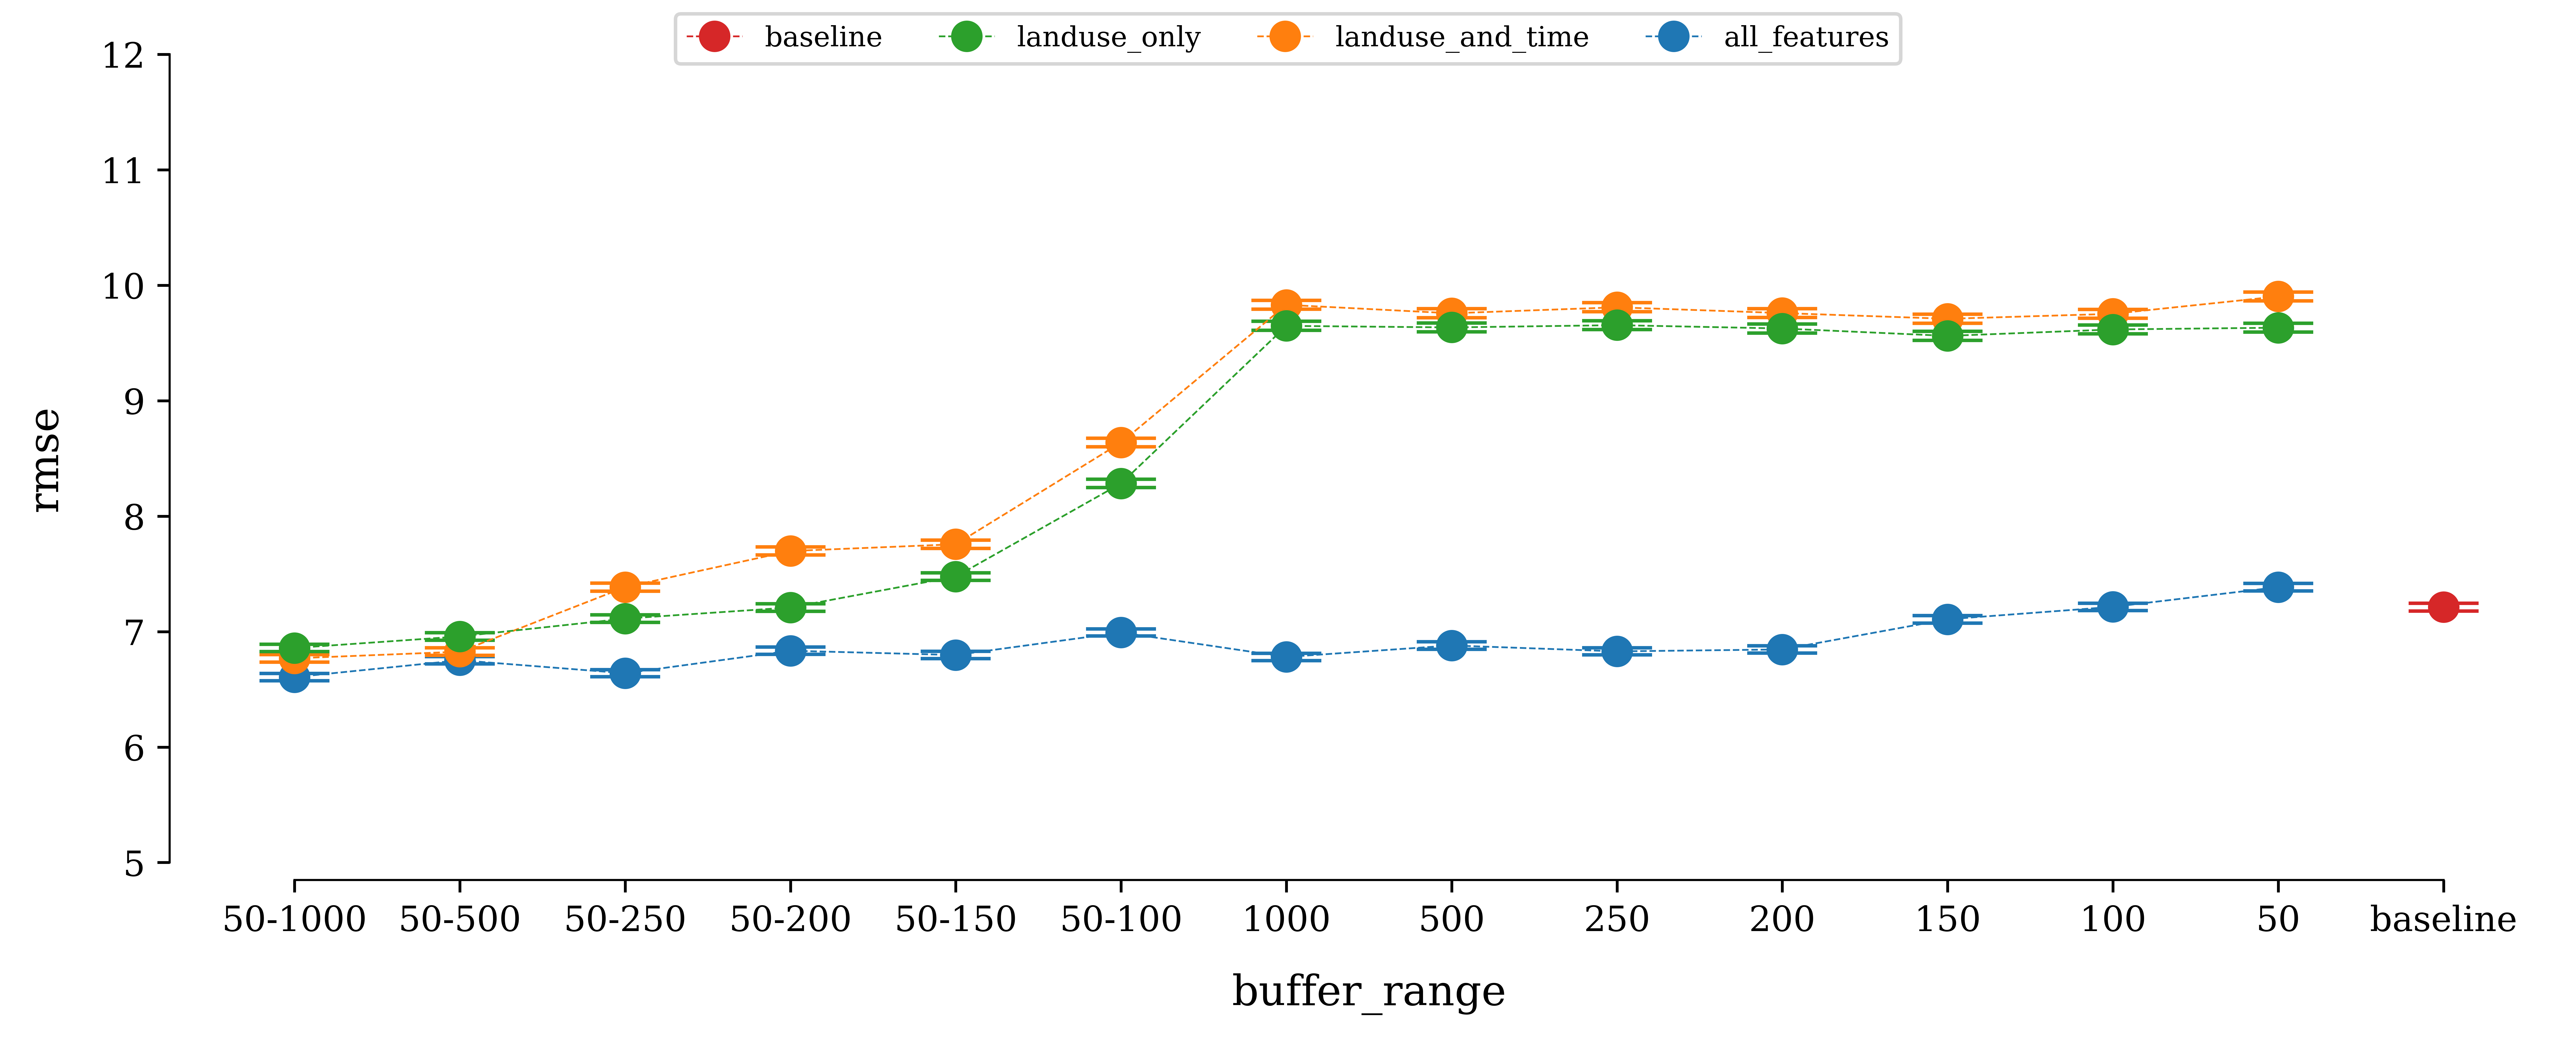

In [8]:
data = bs_test_df
group_key = 'feature_set'
# group by feature set
fig, ax = plt.subplots(figsize=figsize)

metric = 'rmse'
labelpad = 10
label_size = pu.large * 1.2
tick_label_size = pu.large
cmap = {
    'all_features': 'tab:blue',
    'landuse_only': 'tab:green',
    'baseline': 'tab:red',
    'landuse_and_time': 'tab:orange',
}

for name, group in data.groupby(group_key):
    x = group['buffer_range']
    y = group[f'{metric}_mean']
    yerr = group[f'{metric}_ci']

    # get legend for figure level legend
    ax.errorbar(
        x, y, yerr=yerr,
        marker='o', ms=8, capsize=10, lw=0.5,
        ls='--', elinewidth=2, label=name, c=cmap[name],
    )
    ax.legend()
handles, labels = ax.get_legend_handles_labels()

# sort step
hl_dict = dict(zip(labels, handles))
labels = ['baseline', 'landuse_only', 'landuse_and_time', 'all_features']
handles = [hl_dict[i][0] for i in labels]

ax.get_legend().remove()

fig.legend(
    handles, labels, 
    loc='upper center', 
    ncol=4, 
    labelspacing=0,
    fontsize='medium', # xx-small, 'x-xmall', 'small', 'x-large' etc,
    reverse=False,
)

ax.set_xlabel(
    'buffer_range', fontsize=label_size, labelpad=labelpad)

ax.set_ylabel(
    metric, fontsize=label_size, labelpad=labelpad)

ax.tick_params(axis='both', which='major', labelsize=tick_label_size,
)
ax.set_ylim(5, 12)
sns.despine(offset=5, trim=True)
plt.tight_layout()
plt.show()


In [ ]:
data = bs_tscv_df.loc[
    (bs_tscv_df.buffer_range=='50-1000') |
    (bs_tscv_df.buffer_range=='baseline')
]

group_key = 'feature_set'

# group by feature set
figsize = (
    pu.figsizes['double'][0] * 1.5,
    pu.figsizes['double'][1] * 0.8,
  )
fig, ax = plt.subplots(figsize=figsize)

metric = 'rmse'
labelpad = 10
label_size = pu.large * 1.2
tick_label_size = pu.large
cmap = {
    'all_features': 'tab:blue',
    'landuse_only': 'tab:green',
    'baseline': 'tab:red',
    'landuse_and_time': 'tab:orange',
}

for name, group in data.groupby(group_key):
    x = group['fold']
    y = group[f'{metric}_mean']
    yerr = group[f'{metric}_ci']

    # get legend for figure level legend
    ax.errorbar(
        x, y, yerr=yerr,
        marker='o', ms=8, capsize=10, lw=0.5,
        ls='--', elinewidth=2, label=name, c=cmap[name],
    )
    ax.legend()
handles, labels = ax.get_legend_handles_labels()

# sort step
hl_dict = dict(zip(labels, handles))
labels = ['baseline', 'landuse_only', 'landuse_and_time', 'all_features']
handles = [hl_dict[i][0] for i in labels]

ax.get_legend().remove()

fig.legend(
    handles, labels, 
    loc='upper center', 
    ncol=4, 
    labelspacing=0,
    fontsize='medium', # xx-small, 'x-xmall', 'small', 'x-large' etc,
    reverse=False,
)

ax.set_xlabel(
    'fold', fontsize=label_size, labelpad=labelpad)

ax.set_ylabel(
    metric, fontsize=label_size, labelpad=labelpad)

ax.tick_params(axis='both', which='major', labelsize=tick_label_size,
)
ax.set_ylim(5, 12)
sns.despine(offset=5, trim=True)

# plt.tight_layout()
plt.show()


## Other utils

In [ ]:
## preprocess utils
## compress dtypes
dtypes_compressed = {
    'datetime': np.object_,    
    'hour': np.int8,
    'month': np.int8,
    'dayofweek': np.int8,
    'number_of_lanes': np.float32,
    
    'speed_limit_kph': np.float32,    
    
    'lon': np.float64,
    'lat': np.float64,
    'elevation': np.int16,    
    'agg_speed': np.float64,  
    
    'pix_business_4x4_200': np.int16,
    'pix_residential_4x4_200': np.int16,
    'pix_industrial_4x4_200': np.int16,
    'pix_institutional_4x4_200': np.int16,
    'pix_business_4x4_50': np.int16,
    'pix_residential_4x4_50': np.int16,
    'pix_industrial_4x4_50': np.int16,
    'pix_institutional_4x4_50': np.int16,
    'pix_business_4x4_100': np.int16,
    'pix_residential_4x4_100': np.int16,
    'pix_industrial_4x4_100': np.int16,
    'pix_institutional_4x4_100': np.int16,
    'pix_business_4x4_150': np.int16,
    'pix_residential_4x4_150': np.int16,
    'pix_industrial_4x4_150': np.int16,
    'pix_institutional_4x4_150': np.int16,
    'pix_business_4x4_250': np.int16,
    'pix_residential_4x4_250': np.int16,
    'pix_industrial_4x4_250': np.int16,
    'pix_institutional_4x4_250': np.int16,
    'pix_business_4x4_500': np.int16,
    'pix_residential_4x4_500': np.int16,
    'pix_industrial_4x4_500': np.int16,
    'pix_institutional_4x4_500': np.int16,
    'pix_business_4x4_1000': np.int16,
    'pix_residential_4x4_1000': np.int16,
    'pix_industrial_4x4_1000': np.int16,
}

def correct_service_rd_kphlimit(temp_df):
    temp_df.loc[temp_df['speed_limit_kph'] == 36.7, 'speed_limit_kph'] = 20
    return temp_df

def impute_lanes(df):
    df['number_of_lanes'] = df['number_of_lanes'].replace(np.nan, value=2)
    return df

def filter_brgy(df):
    df['barangay'] = df['barangay'].fillna('Out-of-town')
    
    # not in cauayan boundary
    df = df.loc[df['barangay'] != 'Out-of-town'] 
    return df

def filter_num_periods(df, thresh):
    df = df.loc[df['num_periods'] >= thresh]
    return df

def filter_vehicles(df, remove_list=None):
    df = df.loc[~df.vehicle_id.isin(remove_list)]
    return df

def prepare_df(df):
    df = df.astype(dtype=dtypes_compressed)
    
    # vehicles with erratic sending of data; stopped sending data before collection date
    remove_list = [
        123200872653, 123200872678, 
        123200872713, 123200872727, 123200872819,
    ] 
    df = filter_brgy(df)
    df = filter_vehicles(df, remove_list=remove_list)
    df = filter_num_periods(df, thresh=12)
    df = impute_lanes(df)
    df = correct_service_rd_kphlimit(df)
    df = df.drop_duplicates()
    return df
